In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
from keras import layers

import pickle
import torch
import matplotlib.pyplot as plt
import numpy as np
import random

# Setting seeds for reproducibility.
SEED = 42
keras.utils.set_random_seed(SEED)

"""
## Hyperparameters for pretraining

Please feel free to change the hyperparameters and check your results. The best way to
get an intuition about the architecture is to experiment with it. Our hyperparameters are
heavily inspired by the design guidelines laid out by the authors in
[the original paper](https://arxiv.org/abs/2111.06377).
"""

# DATA
BUFFER_SIZE = 1024
BATCH_SIZE = 256
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 10

# OPTIMIZER
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4

# PRETRAINING
EPOCHS = 100

# AUGMENTATION
IMAGE_SIZE = 48  # We will resize input images to this size.
PATCH_SIZE = 6  # Size of the patches to be extracted from the input images.
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
MASK_PROPORTION = 0.75  # We have found 75% masking to give us the best results.

# ENCODER and DECODER
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 128
DEC_PROJECTION_DIM = 64
ENC_NUM_HEADS = 4
ENC_LAYERS = 6
DEC_NUM_HEADS = 4
DEC_LAYERS = (
    2  # The decoder is lightweight but should be reasonably deep for reconstruction.
)
ENC_TRANSFORMER_UNITS = [
    ENC_PROJECTION_DIM * 2,
    ENC_PROJECTION_DIM,
]  # Size of the transformer layers.
DEC_TRANSFORMER_UNITS = [
    DEC_PROJECTION_DIM * 2,
    DEC_PROJECTION_DIM,
]




2024-02-01 11:28:33.219737: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
"""
## Load and prepare the CIFAR-10 dataset
"""

def load_cifar10_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict[b'data'], dict[b'labels']

def load_cifar10_data(data_dir):
    # Initialize the arrays
    x_train = np.empty((0, 3072))
    y_train = []

    # Load each batch file
    for i in range(1, 6):
        filename = os.path.join(data_dir, f'data_batch_{i}')
        data, labels = load_cifar10_batch(filename)
        x_train = np.vstack((x_train, data))
        y_train += labels

    # Load the test batch
    x_test, y_test = load_cifar10_batch(os.path.join(data_dir, 'test_batch'))

    # Reshape the data
    x_train = x_train.reshape((50000, 3, 32, 32)).transpose(0, 2, 3, 1)
    x_test = x_test.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)

    return (x_train, np.array(y_train)), (x_test, np.array(y_test))


cifar10_dir = '/Users/haydenhenderson/Downloads/cifar-10-batches-py.tar.gz'

(x_train, y_train), (x_test, y_test) = load_cifar10_data(cifar10_dir)
(x_train, y_train), (x_val, y_val) = (
    (x_train[:40000], y_train[:40000]),
    (x_train[40000:], y_train[40000:]),
)
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Testing samples: {len(x_test)}")

Training samples: 40000
Validation samples: 10000
Testing samples: 10000


In [3]:
train_ds = tf.data.Dataset.from_tensor_slices(x_train)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices(x_val)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices(x_test)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

In [4]:
"""
## Data augmentation

In previous self-supervised pretraining methodologies
([SimCLR](https://arxiv.org/abs/2002.05709) alike), we have noticed that the data
augmentation pipeline plays an important role. On the other hand the authors of this
paper point out that Masked Autoencoders **do not** rely on augmentations. They propose a
simple augmentation pipeline of:


- Resizing
- Random cropping (fixed-sized or random sized)
- Random horizontal flipping
"""


def get_train_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
            layers.Resizing(INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20),
            layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
            layers.RandomFlip("horizontal"),
        ],
        name="train_data_augmentation",
    )
    return model


def get_test_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
            layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        ],
        name="test_data_augmentation",
    )
    return model

In [5]:
"""
## A layer for extracting patches from images

This layer takes images as input and divides them into patches. The layer also includes
two utility method:

- `show_patched_image` -- Takes a batch of images and its corresponding patches to plot a
random pair of image and patches.
- `reconstruct_from_patch` -- Takes a single instance of patches and stitches them
together into the original image.
"""


class Patches(layers.Layer):
    def __init__(self, patch_size=PATCH_SIZE, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

        # Assuming the image has three channels each patch would be
        # of size (patch_size, patch_size, 3).
        self.resize = layers.Reshape((-1, patch_size * patch_size * 3))

    def call(self, images):
        # Create patches from the input images
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )

        # Reshape the patches to (batch, num_patches, patch_area) and return it.
        patches = self.resize(patches)
        return patches

    def show_patched_image(self, images, patches):
        # This is a utility function which accepts a batch of images and its
        # corresponding patches and help visualize one image and its patches
        # side by side.
        idx = np.random.choice(patches.shape[0])
        print(f"Index selected: {idx}.")

        plt.figure(figsize=(4, 4))
        plt.imshow(keras.utils.array_to_img(images[idx]))
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(patches.shape[1]))
        plt.figure(figsize=(4, 4))
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = tf.reshape(patch, (self.patch_size, self.patch_size, 3))
            plt.imshow(keras.utils.img_to_array(patch_img))
            plt.axis("off")
        plt.show()

        # Return the index chosen to validate it outside the method.
        return idx

    # taken from https://stackoverflow.com/a/58082878/10319735
    def reconstruct_from_patch(self, patch):
        # This utility function takes patches from a *single* image and
        # reconstructs it back into the image. This is useful for the train
        # monitor callback.
        num_patches = patch.shape[0]
        n = int(np.sqrt(num_patches))
        patch = tf.reshape(patch, (num_patches, self.patch_size, self.patch_size, 3))
        rows = tf.split(patch, n, axis=0)
        rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
        reconstructed = tf.concat(rows, axis=0)
        return reconstructed

Index selected: 102.


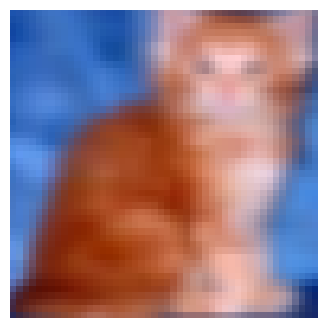

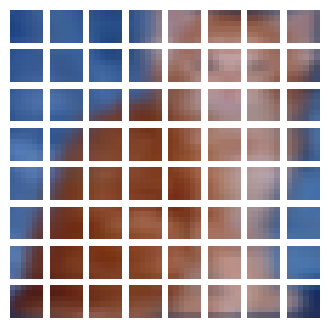

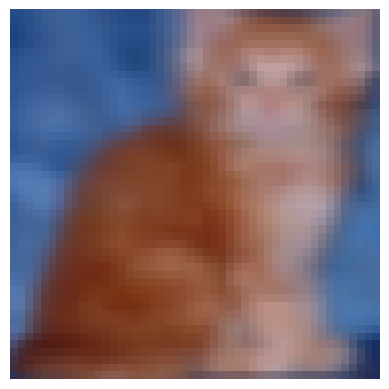

In [6]:
"""
Let's visualize the image patches.
"""

# Get a batch of images.
image_batch = next(iter(train_ds))

# Augment the images.
augmentation_model = get_train_augmentation_model()
augmented_images = augmentation_model(image_batch)

# Define the patch layer.
patch_layer = Patches()

# Get the patches from the batched images.
patches = patch_layer(images=augmented_images)

# Now pass the images and the corresponding patches
# to the `show_patched_image` method.
random_index = patch_layer.show_patched_image(images=augmented_images, patches=patches)

# Chose the same chose image and try reconstructing the patches
# into the original image.
image = patch_layer.reconstruct_from_patch(patches[random_index])
plt.imshow(image)
plt.axis("off")
plt.show()

In [7]:
"""
## Patch encoding with masking

Quoting the paper

> Following ViT, we divide an image into regular non-overlapping patches. Then we sample
a subset of patches and mask (i.e., remove) the remaining ones. Our sampling strategy is
straightforward: we sample random patches without replacement, following a uniform
distribution. We simply refer to this as “random sampling”.

This layer includes masking and encoding the patches.

The utility methods of the layer are:

- `get_random_indices` -- Provides the mask and unmask indices.
- `generate_masked_image` -- Takes patches and unmask indices, results in a random masked
image. This is an essential utility method for our training monitor callback (defined
later).
"""


class PatchEncoder(layers.Layer):
    def __init__(
        self,
        patch_size=PATCH_SIZE,
        projection_dim=ENC_PROJECTION_DIM,
        mask_proportion=MASK_PROPORTION,
        downstream=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.downstream = downstream

        # This is a trainable mask token initialized randomly from a normal
        # distribution.
        self.mask_token = tf.Variable(
            tf.random.normal([1, patch_size * patch_size * 3]), trainable=True
        )

    def build(self, input_shape):
        (_, self.num_patches, self.patch_area) = input_shape

        # Create the projection layer for the patches.
        self.projection = layers.Dense(units=self.projection_dim)

        # Create the positional embedding layer.
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim
        )

        # Number of patches that will be masked.
        self.num_mask = int(self.mask_proportion * self.num_patches)

    def call(self, patches):
        # Get the positional embeddings.
        batch_size = tf.shape(patches)[0]
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(
            pos_embeddings, [batch_size, 1, 1]
        )  # (B, num_patches, projection_dim)

        # Embed the patches.
        patch_embeddings = (
            self.projection(patches) + pos_embeddings
        )  # (B, num_patches, projection_dim)

        if self.downstream:
            return patch_embeddings
        else:
            mask_indices, unmask_indices = self.get_random_indices(batch_size)
            # The encoder input is the unmasked patch embeddings. Here we gather
            # all the patches that should be unmasked.
            unmasked_embeddings = tf.gather(
                patch_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)

            # Get the unmasked and masked position embeddings. We will need them
            # for the decoder.
            unmasked_positions = tf.gather(
                pos_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)
            masked_positions = tf.gather(
                pos_embeddings, mask_indices, axis=1, batch_dims=1
            )  # (B, mask_numbers, projection_dim)

            # Repeat the mask token number of mask times.
            # Mask tokens replace the masks of the image.
            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0
            )

            # Get the masked embeddings for the tokens.
            masked_embeddings = self.projection(mask_tokens) + masked_positions
            return (
                unmasked_embeddings,  # Input to the encoder.
                masked_embeddings,  # First part of input to the decoder.
                unmasked_positions,  # Added to the encoder outputs.
                mask_indices,  # The indices that were masked.
                unmask_indices,  # The indices that were unmaksed.
            )

    def get_random_indices(self, batch_size):
        # Create random indices from a uniform distribution and then split
        # it into mask and unmask indices.
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(batch_size, self.num_patches)), axis=-1
        )
        mask_indices = rand_indices[:, : self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask :]
        return mask_indices, unmask_indices

    def generate_masked_image(self, patches, unmask_indices):
        # Choose a random patch and it corresponding unmask index.
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        unmask_index = unmask_indices[idx]

        # Build a numpy array of same shape as patch.
        new_patch = np.zeros_like(patch)

        # Iterate of the new_patch and plug the unmasked patches.
        count = 0
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx


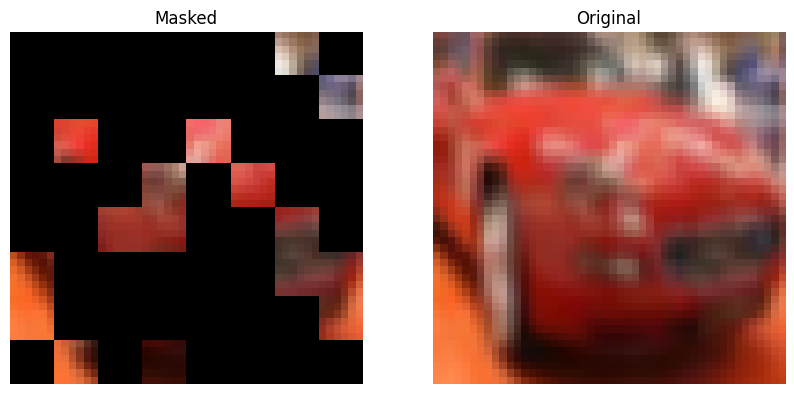

In [8]:
"""
Let's see the masking process in action on a sample image.
"""

# Create the patch encoder layer.
patch_encoder = PatchEncoder()

# Get the embeddings and positions.
(
    unmasked_embeddings,
    masked_embeddings,
    unmasked_positions,
    mask_indices,
    unmask_indices,
) = patch_encoder(patches=patches)


# Show a maksed patch image.
new_patch, random_index = patch_encoder.generate_masked_image(patches, unmask_indices)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
img = patch_layer.reconstruct_from_patch(new_patch)
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Masked")
plt.subplot(1, 2, 2)
img = augmented_images[random_index]
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Original")
plt.show()

In [9]:
"""
## MLP

This serves as the fully connected feed forward network of the transformer architecture.
"""


def mlp(x, dropout_rate, hidden_units):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [10]:
"""
## MAE encoder

The MAE encoder is ViT. The only point to note here is that the encoder outputs a layer
normalized output.
"""


def create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS):
    inputs = layers.Input((None, ENC_PROJECTION_DIM))
    x = inputs

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=ENC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=ENC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    outputs = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    return keras.Model(inputs, outputs, name="mae_encoder")

In [11]:
"""
## MAE decoder

The authors point out that they use an **asymmetric** autoencoder model. They use a
lightweight decoder that takes "<10% computation per token vs. the encoder". We are not
specific with the "<10% computation" in our implementation but have used a smaller
decoder (both in terms of depth and projection dimensions).
"""


def create_decoder(
    num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, image_size=IMAGE_SIZE
):
    inputs = layers.Input((NUM_PATCHES, ENC_PROJECTION_DIM))
    x = layers.Dense(DEC_PROJECTION_DIM)(inputs)

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=DEC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=DEC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    x = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    x = layers.Flatten()(x)
    pre_final = layers.Dense(units=image_size * image_size * 3, activation="sigmoid")(x)
    outputs = layers.Reshape((image_size, image_size, 3))(pre_final)

    return keras.Model(inputs, outputs, name="mae_decoder")


In [12]:

"""
## MAE trainer

This is the trainer module. We wrap the encoder and decoder inside of a `tf.keras.Model`
subclass. This allows us to customize what happens in the `model.fit()` loop.
"""


class MaskedAutoencoder(keras.Model):
    def __init__(
        self,
        train_augmentation_model,
        test_augmentation_model,
        patch_layer,
        patch_encoder,
        encoder,
        decoder,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.train_augmentation_model = train_augmentation_model
        self.test_augmentation_model = test_augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder

    def calculate_loss(self, images, test=False):
        # Augment the input images.
        if test:
            augmented_images = self.test_augmentation_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)

        # Patch the augmented images.
        patches = self.patch_layer(augmented_images)

        # Encode the patches.
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)

        # Pass the unmaksed patche to the encoder.
        encoder_outputs = self.encoder(unmasked_embeddings)

        # Create the decoder inputs.
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)

        # Decode the inputs.
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)

        loss_patch = tf.gather(patches, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_patches, mask_indices, axis=1, batch_dims=1)

        # Compute the total loss.
        total_loss = self.compute_loss(y=loss_patch, y_pred=loss_output)

        return total_loss, loss_patch, loss_output

    def train_step(self, images):
        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output = self.calculate_loss(images)

        # Apply gradients.
        train_vars = [
            self.train_augmentation_model.trainable_variables,
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for grad, var in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)

        # Report progress.
        results = {}
        for metric in self.metrics:
            metric.update_state(loss_patch, loss_output)
            results[metric.name] = metric.result()
        return results

    def test_step(self, images):
        total_loss, loss_patch, loss_output = self.calculate_loss(images, test=True)

        # Update the trackers.
        results = {}
        for metric in self.metrics:
            metric.update_state(loss_patch, loss_output)
            results[metric.name] = metric.result()
        return results

In [13]:
"""
## Model initialization
"""

train_augmentation_model = get_train_augmentation_model()
test_augmentation_model = get_test_augmentation_model()
patch_layer = Patches()
patch_encoder = PatchEncoder()
encoder = create_encoder()
decoder = create_decoder()

mae_model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)


In [14]:
"""
## Training callbacks
"""

"""
### Visualization callback
"""

# Taking a batch of test inputs to measure model's progress.
test_images = next(iter(test_ds))


class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            test_augmented_images = self.model.test_augmentation_model(test_images)
            test_patches = self.model.patch_layer(test_augmented_images)
            (
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
                test_mask_indices,
                test_unmask_indices,
            ) = self.model.patch_encoder(test_patches)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = tf.concat(
                [test_encoder_outputs, test_masked_embeddings], axis=1
            )
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)

            # Show a maksed patch image.
            test_masked_patch, idx = self.model.patch_encoder.generate_masked_image(
                test_patches, test_unmask_indices
            )
            print(f"\nIdx chosen: {idx}")
            original_image = test_augmented_images[idx]
            masked_image = self.model.patch_layer.reconstruct_from_patch(
                test_masked_patch
            )
            reconstructed_image = test_decoder_outputs[idx]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
            ax[0].imshow(original_image)
            ax[0].set_title(f"Original: {epoch:03d}")

            ax[1].imshow(masked_image)
            ax[1].set_title(f"Masked: {epoch:03d}")

            ax[2].imshow(reconstructed_image)
            ax[2].set_title(f"Resonstructed: {epoch:03d}")

            plt.show()
            plt.close()


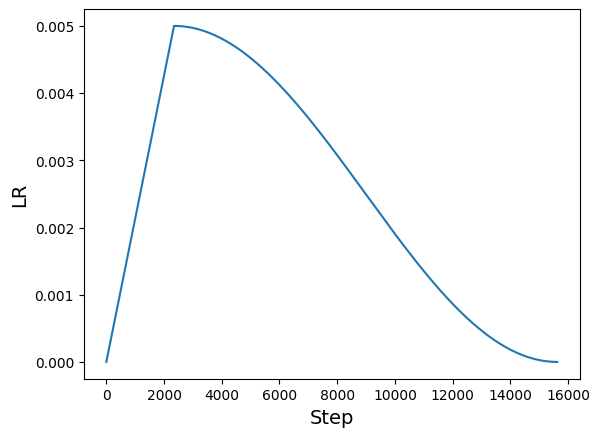

In [15]:
"""
### Learning rate scheduler
"""

# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.


class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

lrs = [scheduled_lrs(step) for step in range(total_steps)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

# Assemble the callbacks.
train_callbacks = [TrainMonitor(epoch_interval=5)]


In [16]:
"""
## Model compilation and training
"""

optimizer = keras.optimizers.AdamW(
    learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY
)

# Compile and pretrain the model.
mae_model.compile(
    optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"]
)
history = mae_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=train_callbacks,
)

# Measure its performance.
loss, mae = mae_model.evaluate(test_ds)
print(f"Loss: {loss:.2f}")
print(f"MAE: {mae:.2f}")

Epoch 1/100
133/157 [========================>.....] - ETA: 49s - loss: 0.4913

KeyboardInterrupt: 

In [ ]:
"""
## Evaluation with linear probing
"""

"""
### Extract the encoder model along with other layers
"""

# Extract the augmentation layers.
train_augmentation_model = mae_model.train_augmentation_model
test_augmentation_model = mae_model.test_augmentation_model

# Extract the patchers.
patch_layer = mae_model.patch_layer
patch_encoder = mae_model.patch_encoder
patch_encoder.downstream = True  # Swtich the downstream flag to True.

# Extract the encoder.
encoder = mae_model.encoder

# Pack as a model.
downstream_model = keras.Sequential(
    [
        layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        patch_layer,
        patch_encoder,
        encoder,
        layers.BatchNormalization(),  # Refer to A.1 (Linear probing).
        layers.GlobalAveragePooling1D(),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ],
    name="linear_probe_model",
)

# Only the final classification layer of the `downstream_model` should be trainable.
for layer in downstream_model.layers[:-1]:
    layer.trainable = False

downstream_model.summary()

In [ ]:
"""
We are using average pooling to extract learned representations from the MAE encoder.
Another approach would be to use a learnable dummy token inside the encoder during
pretraining (resembling the [CLS] token). Then we can extract representations from that
token during the downstream tasks.
"""

"""
### Prepare datasets for linear probing
"""


def prepare_data(images, labels, is_train=True):
    if is_train:
        augmentation_model = train_augmentation_model
    else:
        augmentation_model = test_augmentation_model

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.batch(BATCH_SIZE).map(
        lambda x, y: (augmentation_model(x), y), num_parallel_calls=AUTO
    )
    return dataset.prefetch(AUTO)


train_ds = prepare_data(x_train, y_train)
val_ds = prepare_data(x_train, y_train, is_train=False)
test_ds = prepare_data(x_test, y_test, is_train=False)


In [ ]:
"""
### Perform linear probing
"""

linear_probe_epochs = 50
linear_prob_lr = 0.1
warm_epoch_percentage = 0.1
steps = int((len(x_train) // BATCH_SIZE) * linear_probe_epochs)

warmup_steps = int(steps * warm_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=linear_prob_lr,
    total_steps=steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

optimizer = keras.optimizers.SGD(learning_rate=scheduled_lrs, momentum=0.9)
downstream_model.compile(
    optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
downstream_model.fit(train_ds, validation_data=val_ds, epochs=linear_probe_epochs)

loss, accuracy = downstream_model.evaluate(test_ds)
accuracy = round(accuracy * 100, 2)
print(f"Accuracy on the test set: {accuracy}%.")

In [ ]:
"""
We believe that with a more sophisticated hyperparameter tuning process and a longer
pretraining it is possible to improve this performance further. For comparison, we took
the encoder architecture and
[trained it from scratch](https://github.com/ariG23498/mae-scalable-vision-learners/blob/master/regular-classification.ipynb)
in a fully supervised manner. This gave us ~76% test top-1 accuracy. The authors of
MAE demonstrates strong performance on the ImageNet-1k dataset as well as
other downstream tasks like object detection and semantic segmentation.
"""

"""
## Final notes

We refer the interested readers to other examples on self-supervised learning present on
keras.io:

* [SimCLR](https://keras.io/examples/vision/semisupervised_simclr/)
* [NNCLR](https://keras.io/examples/vision/nnclr)
* [SimSiam](https://keras.io/examples/vision/simsiam)

This idea of using BERT flavored pretraining in computer vision was also explored in
[Selfie](https://arxiv.org/abs/1906.02940), but it could not demonstrate strong results.
Another concurrent work that explores the idea of masked image modeling is
[SimMIM](https://arxiv.org/abs/2111.09886). Finally, as a fun fact, we, the authors of
this example also explored the idea of ["reconstruction as a pretext task"](https://i.ibb.co/k5CpwDX/image.png)
in 2020 but we could not prevent the network from representation collapse, and
hence we did not get strong downstream performance.

We would like to thank [Xinlei Chen](http://xinleic.xyz/)
(one of the authors of MAE) for helpful discussions. We are grateful to
[JarvisLabs](https://jarvislabs.ai/) and
[Google Developers Experts](https://developers.google.com/programs/experts/)
program for helping with GPU credits.
"""